<a href="https://colab.research.google.com/github/RoccoGiugni/ASML-24-25/blob/main/L19/L19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXERCISE 14 - SDSS Galaxies vs Quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g.

- Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- Quasar and galaxy classification in Gaia Data Release 2 Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

## IMPORT MODULES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, loguniform, norm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_auc_score

In [ ]:
# Install packages if working on colab
!pip install astroML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
from astroML.classification import GMMBayes

## LOAD DATA FILE

In [ ]:
github_url = 'https://raw.githubusercontent.com/RoccoGiugni/astrostatistics_bicocca_2025/refs/heads/main/solutions/galaxyquasar.csv'

try:
    df_gal_qso = pd.read_csv(github_url) # load the dataset into a pandas DataFrame
    print("Dataset loaded successfully from GitHub!")
except Exception as e:
    print(f"Error loading dataset from GitHub: {e}")
    print("Please ensure the URL is correct and points to a raw file.")

Dataset loaded successfully from GitHub!


# L19:

## Tasks

- Create arrays for the $(u - g)$, $(g - r)$, $(r - i)$, and $(i - z)$ colors. Also create an array with the class labels where galaxy=0 and quasar=1.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

## Ideas

- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

# 1 - DATA SELECTION

In [ ]:
le = LabelEncoder()

df_gal_qso['class'] = le.fit_transform(df_gal_qso['class'])

labels = le.inverse_transform(df_gal_qso['class'])
class_names = le.classes_

# Color columns
df_gal_qso['u-g'] = df_gal_qso['u'] - df_gal_qso['g']
df_gal_qso['g-r'] = df_gal_qso['g'] - df_gal_qso['r']
df_gal_qso['r-i'] = df_gal_qso['r'] - df_gal_qso['i']
df_gal_qso['i-z'] = df_gal_qso['i'] - df_gal_qso['z']

In [ ]:
# Data set-up for sklearn

X = df_gal_qso[['u-g', 'g-r', 'r-i', 'i-z']].values
y = df_gal_qso[['class']].values.ravel() #.values to get a numpy array, .ravel() to get a 1D array

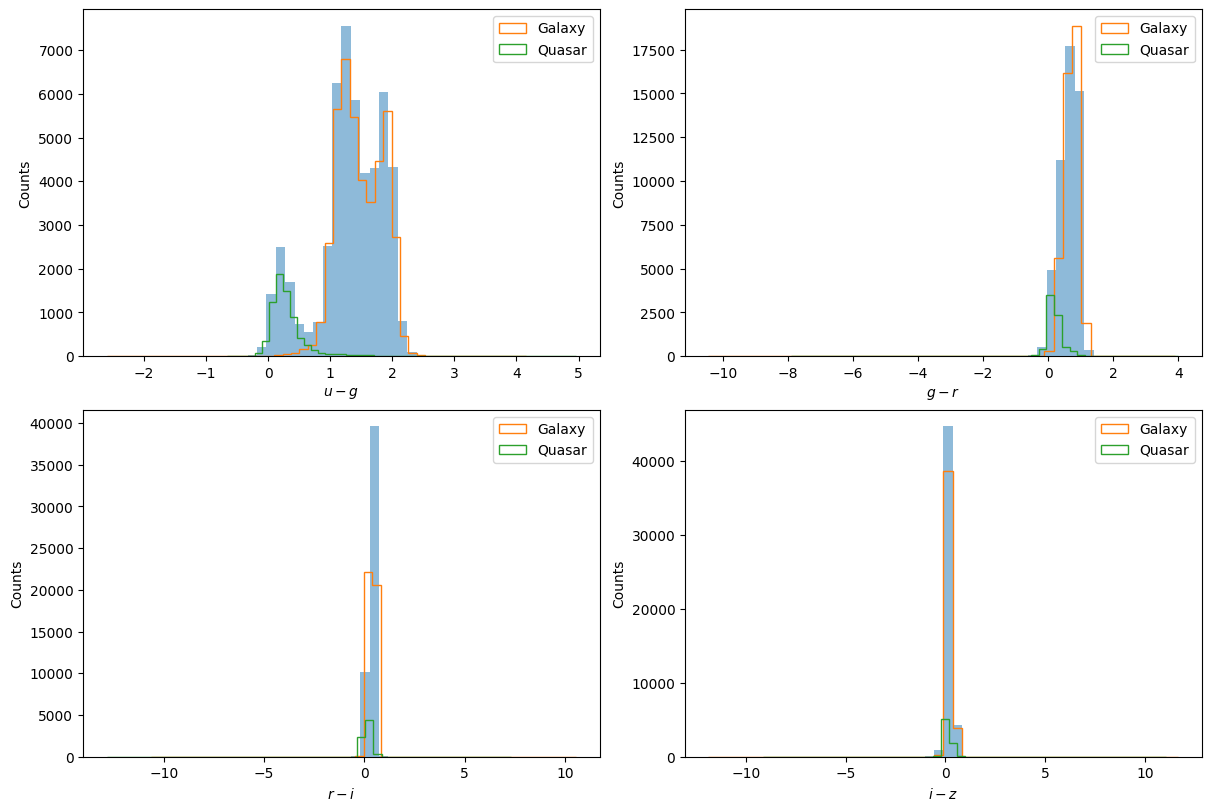

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

for i, color in enumerate(['u-g', 'g-r', 'r-i', 'i-z']):
  ax = axs[i // 2, i % 2]
  ax.hist(X[:, i], bins=50, alpha=.5)
  ax.hist(X[:, i][y == 0], bins=50, histtype='step', label='Galaxy')
  ax.hist(X[:, i][y == 1], bins=50, histtype='step', label='Quasar')

  ax.set_xlabel(f'${color}$')
  ax.set_ylabel('Counts')
  ax.legend();

# 2 - CLASSIFICATION ALGORITHMS COMPARISON

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


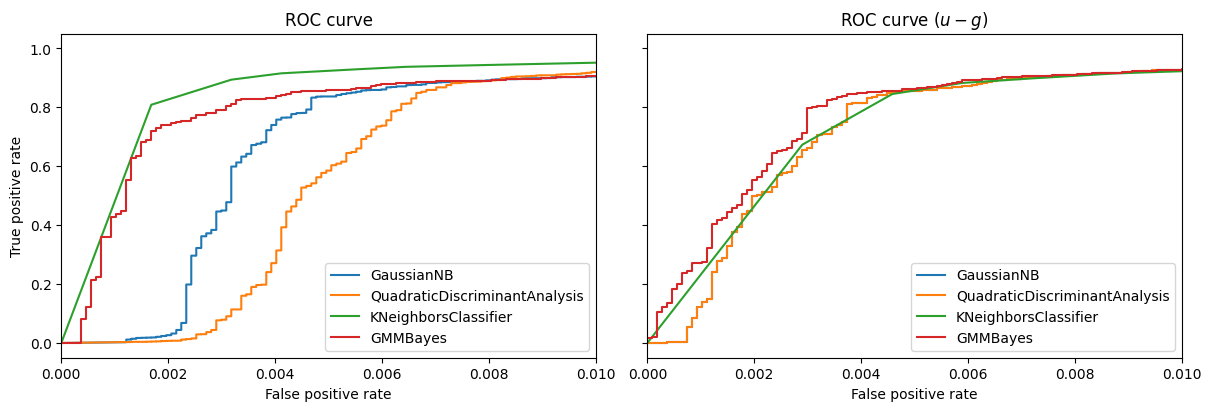

In [ ]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='constrained')

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=.25, random_state=42)

classifiers = [GaussianNB, QuadraticDiscriminantAnalysis, KNeighborsClassifier, GMMBayes]
kwargs = [{}, {}, {'n_neighbors': 10}, {'n_components': 3, 'tol': 1e-5, 'covariance_type': 'full'}]

roc_auc = np.zeros((len(classifiers), 2))
acc = np.zeros((len(classifiers), 2))
comp = np.zeros((len(classifiers), 2))
cont = np.zeros((len(classifiers), 2))

for i, (classifier, kwarg) in enumerate(zip(classifiers, kwargs)):
    clf = classifier(**kwarg)

    # All colors
    clf.fit(X_trn, y_trn)

    y_prob = clf.predict_proba(X_tst)[:, 1]
    fpr, tpr, thresh = roc_curve(y_tst, y_prob)

    ax.plot(fpr, tpr, label=f'{classifier.__name__}')

    roc_auc[i, 0] = roc_auc_score(y_tst, y_prob)
    acc[i, 0] = accuracy_score(y_tst, clf.predict(X_tst))
    tp, fp, fn, tn = confusion_matrix(y_tst, clf.predict(X_tst)).ravel()
    comp[i, 0] = tp / (tp + fn)
    cont[i, 0] = fp / (tp + fp)

    # Only u-g
    clf.fit(X_trn[:, 0].reshape(-1, 1), y_trn)

    x_tst = X_tst[:, 0].reshape(-1, 1)
    y_prob = clf.predict_proba(x_tst)[:, 1]
    fpr, tpr, thresh = roc_curve(y_tst, y_prob)

    bx.plot(fpr, tpr, label=f'{classifier.__name__}')

    roc_auc[i, 1] = roc_auc_score(y_tst, y_prob)
    acc[i, 1] = accuracy_score(y_tst, clf.predict(x_tst))
    tp, fp, fn, tn = confusion_matrix(y_tst, clf.predict(x_tst)).ravel()
    comp[i, 1] = tp / (tp + fn)
    cont[i, 1] = fp / (tp + fp)

ax.set_xlim(0, .01)
bx.set_xlim(0, .01)

ax.set_title('ROC curve')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()

bx.set_title('ROC curve $(u-g)$')
bx.set_xlabel('False positive rate')
bx.legend();

In [ ]:
print(' --- ALL COLORS ---\n')
print('ROC AUC\tAccuracy\tCompleteness\tContamination')
print(f'{roc_auc[0, 0]:.3f}\t{acc[0, 0]:.3f}\t\t{comp[0, 0]:.3f}\t\t{cont[0, 0]:.3f}\t{classifiers[0].__name__}')
print(f'{roc_auc[1, 0]:.3f}\t{acc[1, 0]:.3f}\t\t{comp[1, 0]:.3f}\t\t{cont[1, 0]:.3f}\t{classifiers[1].__name__}')
print(f'{roc_auc[2, 0]:.3f}\t{acc[2, 0]:.3f}\t\t{comp[2, 0]:.3f}\t\t{cont[2, 0]:.3f}\t{classifiers[2].__name__}')
print(f'{roc_auc[3, 0]:.3f}\t{acc[3, 0]:.3f}\t\t{comp[3, 0]:.3f}\t\t{cont[3, 0]:.3f}\t{classifiers[3].__name__}')

print('\n\n')
print(' --- u - g ---\n')
print('ROC AUC\tAccuracy\tCompleteness\tContamination')
print(f'{roc_auc[0, 1]:.3f}\t{acc[0, 1]:.3f}\t\t{comp[0, 1]:.3f}\t\t{cont[0, 1]:.3f}\t{classifiers[0].__name__}')
print(f'{roc_auc[1, 1]:.3f}\t{acc[1, 1]:.3f}\t\t{comp[1, 1]:.3f}\t\t{cont[1, 1]:.3f}\t{classifiers[1].__name__}')
print(f'{roc_auc[2, 1]:.3f}\t{acc[2, 1]:.3f}\t\t{comp[2, 1]:.3f}\t\t{cont[2, 1]:.3f}\t{classifiers[2].__name__}')
print(f'{roc_auc[3, 1]:.3f}\t{acc[3, 1]:.3f}\t\t{comp[3, 1]:.3f}\t\t{cont[3, 1]:.3f}\t{classifiers[3].__name__}')

 --- ALL COLORS ---

ROC AUC	Accuracy	Completeness	Contamination
0.976	0.975		0.988		0.017	GaussianNB
0.981	0.980		0.987		0.010	QuadraticDiscriminantAnalysis
0.984	0.985		0.989		0.006	KNeighborsClassifier
0.988	0.970		0.990		0.026	GMMBayes



 --- u - g ---

ROC AUC	Accuracy	Completeness	Contamination
0.979	0.981		0.988		0.010	GaussianNB
0.979	0.981		0.988		0.010	QuadraticDiscriminantAnalysis
0.976	0.980		0.986		0.009	KNeighborsClassifier
0.983	0.981		0.986		0.009	GMMBayes
